# Time Series Forecasting with Dart Theta of models

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional
from darts import models, backtesting, metrics
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
from statsmodels.tsa.seasonal import seasonal_decompose 

%matplotlib inline

In [8]:
pd.plotting.register_matplotlib_converters()


# Dart

## Train one model for each entity

In [9]:
df = pd.read_csv("meli_data.csv")
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
df.head()

,date,campaign,campaign_id,target_roas,cost,impressions,clicks,ctr,conversions,conversion_value,...,impressions_slope_14_21,clicks_slope_14_21,ctr_slope_14_21,conversions_slope_14_21,conversion_value_slope_14_21,gmv_matt_slope_14_21,gmv_shapley_slope_14_21,gmv_stimulus_slope_14_21,cost_slope_14_21,site
0,2020-01-01,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,3714.71,6115306.0,119391.0,1.95,1264.49,275264.54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
1,2020-01-02,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,6481.04,10483061.0,211379.0,2.02,2920.71,667247.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
2,2020-01-03,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,5858.64,10210427.0,197818.0,1.94,2495.05,543083.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
3,2020-01-04,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,6031.34,9646553.0,189609.0,1.97,2325.83,447982.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
4,2020-01-05,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,6204.97,9702296.0,193787.0,2.00,2437.50,450986.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb


In [10]:
len(df.campaign_id.unique())

75

## Fill missing values
TimeSeries add missing date with nan values, and you have to fillna values with `auto_fillna` function

In [15]:
def create_time_series(df:pd.DataFrame) -> TimeSeries:
    """
    Create a time series filling missing dates and filling the values of those mising dates.
    and then split the entire ts in val and train.

    Parameters
    ----------
    df
        pandas dataframe.
    
    Returns
    -------
    TimeSeries
        The TimeSeries filled.
    """
    df = df[df.net_revenue != 0]
    series = TimeSeries.from_dataframe(df, "date", "net_revenue" )
    series = missing_values.auto_fillna(series, method="slinear")

    return series 

In [58]:
def fit_predict_theta(train, val):
    thetas = np.linspace(-10, 10, 50)

    best_mape = float('inf')
    best_theta = 0

    for theta in thetas:
        model = models.Theta(theta)
        model.fit(train)
        pred_theta = model.predict(len(val))
        res = metrics.mape(val, pred_theta)
        
        if res < best_mape:
            best_mape = res
            best_theta = theta

    best_theta_model = models.Theta(best_theta)
    best_theta_model.fit(train)
    pred_best_theta = best_theta_model.predict(len(val))

    return pred_best_theta, best_theta

In [59]:
campains = df.campaign_id.unique()
error_dict = {}
thetas_dict = {}
date_division = "20200625"

for campain in campains:
    df_campain = df[df.campaign_id == campain]
    if len(df_campain) > 100:
        try :
            series = create_time_series(df_campain)
            train, val = series.split_before(pd.Timestamp(date_division))
            pred, best_thet= fit_predict_theta(train, val)
            error = metrics.mape(val, pred)
            error_dict[campain] = error
            thetas_dict[campain] = best_thet
        except:
            print("error in entity: " + str(campain))
            pass

7 13:59:05,409] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:05,486] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:05,579] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:05,669] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:05,738] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:05,813] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:05,913] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:05,984] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:06,054] INFO | darts.models.theta | Theta model inferred seasonality of training series: 7
[2020-07-27 13:59:06,111] INF

In [60]:
error_dict

{6542458279: 5.839380553329929,
 6542484841: 5.657995968025571,
 6542484859: 8.747045587051392,
 6542484922: 8.102166897634442,
 6542489221: 6.888288661148824,
 6542508691: 7.849270670301099,
 6542509144: 7.761220082180194,
 6542509648: 8.458438774748927,
 6542510092: 8.484523484182983,
 6542512723: 6.285649208109984,
 6542513413: 8.980197043495338,
 6542745839: 12.926454841344153,
 6542746532: 7.07828433124499,
 6542746973: 9.966058880213215,
 6542860500: 4.403883670614475,
 6542933197: 25.427518783162167,
 6542939187: 19.700265926559073,
 6542955276: 5.339061367522326,
 6543179201: 16.01010934566697,
 6543332358: 7.287341793322113,
 6543359910: 9.452853315561093,
 6543360237: 31.96206478435576,
 6543165727: 30.389078174299268,
 6543208723: 22.014192077639354,
 6543245170: 23.044364949244667,
 6543247363: 11.13279437720178,
 6543386777: 15.127850766641075,
 6543404282: 8.962820270189935,
 6543465836: 14.505405583476385,
 6543520502: 23.989844000690837,
 6543615747: 20.835949450643195,

Text(0.5, 1.0, 'Average MAPE Error Theta: 18.68%')

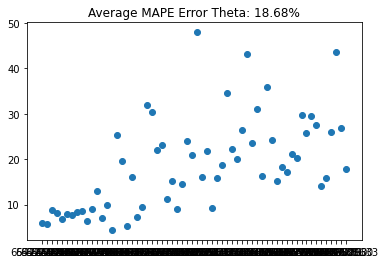

In [61]:
x = [*map(str,error_dict.keys())]
y = error_dict.values()
plt.scatter(x,y )
plt.title('Average MAPE Error Theta: {:.2f}%'.format(np.mean(list(y))))